In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from patsy import dmatrices

In [4]:
housing = pd.read_csv("housing_renamed.csv")
housing.head()

,neighborhood,type,units,year_built,sq_ft,income,income_per_sq_ft,expense,expense_per_sq_ft,net_income,value,value_per_sq_ft,boro
0,FINANCIAL,R9-CONDOMINIUM,42,1920.0,36500,1332615,36.51,342005,9.37,990610,7300000,200.00,Manhattan
1,FINANCIAL,R4-CONDOMINIUM,78,1985.0,126420,6633257,52.47,1762295,13.94,4870962,30690000,242.76,Manhattan
2,FINANCIAL,RR-CONDOMINIUM,500,NaN,554174,17310000,31.24,3543000,6.39,13767000,90970000,164.15,Manhattan
3,FINANCIAL,R4-CONDOMINIUM,282,1930.0,249076,11776313,47.28,2784670,11.18,8991643,67556006,271.23,Manhattan
4,TRIBECA,R4-CONDOMINIUM,239,1985.0,219495,10004582,45.58,2783197,12.68,7221385,54320996,247.48,Manhattan


In [6]:
# regressão linear múltpla com o statsmodels
house1 = smf.glm("value_per_sq_ft ~ units + sq_ft + boro",
                data = housing).fit()

house1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        value_per_sq_ft   No. Observations:                 2626
Model:                            GLM   Df Residuals:                     2619
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1879.5
Method:                          IRLS   Log-Likelihood:                -13621.
Date:                Wed, 24 Aug 2022   Deviance:                   4.9224e+06
Time:                        15:40:08   Pearson chi2:                 4.92e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                43.2909      5.330      8.122      0.000      32.845      53.737
boro[T.Brooklyn]         34.5621      5.535      6.244      0.000      23.714      45.411
boro[T.Manhattan]       130.9924      5.385     24.327      0.000     120.439     141.546
boro[T.Queens]           32.9937      5.663      5.827      0.000      21.895      44.092
boro[T.Staten Island]    -3.6303      9.993     -0.363      0.716     -23.216      15.956
units                    -0.1881      0.022     -8.511      0.000      -0.231      -0.145
sq_ft                     0.0002   2.09e-05     10.079      0.000       0.000       0.000
=========================================================================================
"""

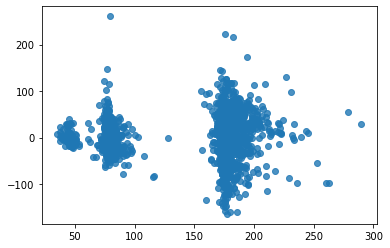

In [13]:
fig, ax = plt.subplots()
ax = sns.regplot(x = house1.fittedvalues,
                y = house1.resid_deviance,
                 fit_reg = False)

plt.show()

fig.savefig("1. resid_1.jpg")

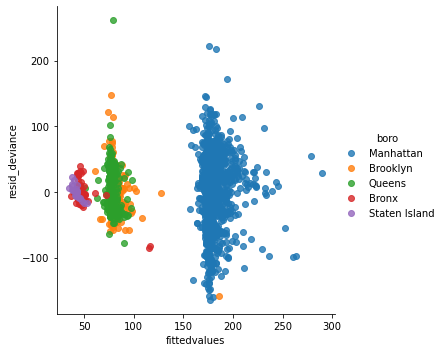

In [14]:
# replotando a figura anterior, mas agora separado pela variável boro
res_df = pd.DataFrame({
    "fittedvalues": house1.fittedvalues,
    "resid_deviance": house1.resid_deviance,
    "boro": housing["boro"]})

fig = sns.lmplot(x = "fittedvalues", y = "resid_deviance",
               data = res_df, hue = "boro", fit_reg = False)

plt.show()

fig.savefig("2. resid_boros.jpg")

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


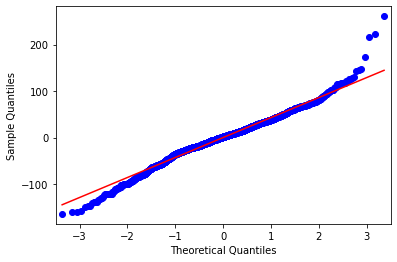

In [15]:
# q-q plot
resid = house1.resid_deviance.copy()
resid_std = stats.zscore(resid) # resíduo padronizado

fig = statsmodels.graphics.gofplots.qqplot(resid, line = "r")
plt.show()

fig.savefig("3. house_1_qq.jpg")

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


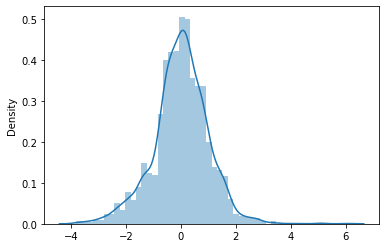

In [16]:
fig, ax = plt.subplots()
ax = sns.distplot(resid_std)
plt.show()

fig.savefig("4. house_resid_std.jpg")

In [23]:
# o conjunto de dados originais de habitação tem uma coluna chamada class;
# isso causaria um erro se usássemos "class"
# porque essa é uma palavra reservada de Python;
# a coluna foi renomeada para "type"
f1 = "value_per_sq_ft ~ units + sq_ft + boro"
f2 = "value_per_sq_ft ~ units * sq_ft + boro"
f3 = "value_per_sq_ft ~ units + sq_ft * boro + type"
f4 = "value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type"
f5 = "value_per_sq_ft ~ boro + type"

house1 = smf.ols(f1, data = housing).fit()
house2 = smf.ols(f2, data = housing).fit()
house3 = smf.ols(f3, data = housing).fit()
house4 = smf.ols(f4, data = housing).fit()
house5 = smf.ols(f5, data = housing).fit()

model_results = pd.concat([house1.params,
                          house2.params,
                          house3.params,
                          house4.params,
                          house5.params],
                        axis = 1).rename(columns = 
                                         lambda x: 'house' + str(x + 1)
                                        ).reset_index().rename(columns = 
                                                               {"index": "param"}).melt(id_vars = "param",
                                                                                        var_name = "model",
                                                                                        value_name = "estimate")

model_results

,param,model,estimate
0,Intercept,house1,43.290863
1,boro[T.Brooklyn],house1,34.562150
2,boro[T.Manhattan],house1,130.992363
3,boro[T.Queens],house1,32.993674
4,boro[T.Staten Island],house1,-3.630251
...,...,...,...
85,sq_ft:boro[T.Queens],house5,NaN
86,sq_ft:boro[T.Staten Island],house5,NaN
87,sq_ft:type[T.R4-CONDOMINIUM],house5,NaN
88,sq_ft:type[T.R9-CONDOMINIUM],house5,NaN


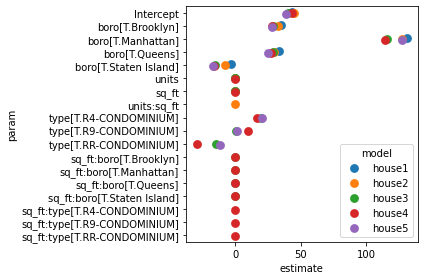

In [24]:
fig, ax = plt.subplots()
ax = sns.pointplot(x = "estimate",
                  y = "param",
                  hue = "model",
                  data = model_results,
                  dodge = True, # jitter nos pontos
                  join = False) # não conecta os pontos

plt.tight_layout()
plt.show()

In [27]:
# ANOVAs comparando modelos
model_names = ["house" + str(i) for i in range(1, 6)]
house_anova = statsmodels.stats.anova.anova_lm(house1, house2, house3, house4, house5)
house_anova.index = model_names
house_anova

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
house1,2619.0,4.922389e+06,0.0,NaN,NaN,NaN
house2,2618.0,4.884872e+06,1.0,37517.437605,20.039049,7.912333e-06
house3,2612.0,4.619926e+06,6.0,264945.539994,23.585728,2.754431e-27
house4,2609.0,4.576671e+06,3.0,43255.441192,7.701289,4.025581e-05
house5,2618.0,4.901463e+06,-9.0,-324791.847907,19.275539,NaN


In [31]:
# trabalhando com modelos GLM
def anova_deviance_table(*models):
    return pd.DataFrame({
        "df_residuals": [i.df_resid for i in models],
        #"resid_stddev": [i.deviance for i in models],
        "df": [i.df_model for i in models],
        #"deviance": [i.deviance for i in models]
    })

f1 = "value_per_sq_ft ~ units + sq_ft + boro"
f2 = "value_per_sq_ft ~ units * sq_ft + boro"
f3 = "value_per_sq_ft ~ units + sq_ft * boro + type"
f4 = "value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type"
f5 = "value_per_sq_ft ~ boro + type"

glm1 = smf.ols(f1, data = housing).fit()
glm2 = smf.ols(f2, data = housing).fit()
glm3 = smf.ols(f3, data = housing).fit()
glm4 = smf.ols(f4, data = housing).fit()
glm5 = smf.ols(f5, data = housing).fit()

glm_anova = anova_deviance_table(glm1, glm2, glm3, glm4, glm5)
glm_anova

,df_residuals,df
0,2619.0,6.0
1,2618.0,7.0
2,2612.0,13.0
3,2609.0,16.0
4,2618.0,7.0


In [32]:
# fazendo o mesmo em uma regressão logística

# cria uma variável binária
housing["high_value"] = (housing["value_per_sq_ft"] >= 150).astype(int)
housing["high_value"].value_counts()

0    1619
1    1007
Name: high_value, dtype: int64

In [33]:
# cria e faz a adequação à nossa regressão logística usando GLM
f1 = "value_per_sq_ft ~ units + sq_ft + boro"
f2 = "value_per_sq_ft ~ units * sq_ft + boro"
f3 = "value_per_sq_ft ~ units + sq_ft * boro + type"
f4 = "value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type"
f5 = "value_per_sq_ft ~ boro + type"

logistic = statsmodels.genmod.families.family.Binomial(link = statsmodels.genmod.families.links.logit)

glm1 = smf.glm(f1, data = housing, family = logistic).fit()
glm2 = smf.glm(f2, data = housing, family = logistic).fit()
glm3 = smf.glm(f3, data = housing, family = logistic).fit()
glm4 = smf.glm(f4, data = housing, family = logistic).fit()
glm5 = smf.glm(f5, data = housing, family = logistic).fit()

# mostra os desvios de nossos modelos GLM
anova_deviance_table(glm1, glm2, glm3, glm4, glm5)

C:\Users\User\AppData\Local\Temp/ipykernel_5628/351959334.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  logistic = statsmodels.genmod.families.family.Binomial(link = statsmodels.genmod.families.links.logit)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


,df_residuals,df
0,2619,6
1,2618,7
2,2612,13
3,2609,16
4,2618,7


In [36]:
# validação cruzada k-fold
housing.columns

Index(['neighborhood', 'type', 'units', 'year_built', 'sq_ft', 'income',
       'income_per_sq_ft', 'expense', 'expense_per_sq_ft', 'net_income',
       'value', 'value_per_sq_ft', 'boro', 'high_value'],
      dtype='object')

In [37]:
# obtém os dados de treinamento e de teste
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(housing[["units", "sq_ft", "boro"]],
                   drop_first = True),
    housing["value_per_sq_ft"],
    test_size = 0.20,
    random_state = 42
)

In [38]:
# ajuste do modelo usando os dados de treino
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.6137125285030869

In [42]:
# idem ao código anterior, mas usando dmatrices da biblioteca patsy
y, X = dmatrices("value_per_sq_ft ~ units + sq_ft + boro", housing,
                return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(housing[["units", "sq_ft", "boro"]],
                   drop_first = True),
    housing["value_per_sq_ft"],
    test_size = 0.20,
    random_state = 42
)

lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.6137125285030869

In [44]:
# finalmente, a vlidação cruzada k-fold
housing = pd.read_csv("housing_renamed.csv")

kf = KFold(n_splits = 5)

y, X = dmatrices("value_per_sq_ft ~ units + sq_ft + boro", housing)

coefs = []
scores = []

for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    lr = LinearRegression().fit(X_train, y_train)
    coefs.append(pd.DataFrame(lr.coef_))
    scores.append(lr.score(X_test, y_test))
    
coefs_df = pd.concat(coefs)
coefs_df.columns = X.design_info.column_names
coefs_df

,Intercept,boro[T.Brooklyn],boro[T.Manhattan],boro[T.Queens],boro[T.Staten Island],units,sq_ft
0,0.0,33.369037,129.904011,32.103100,-4.381085,-0.205890,0.000220
0,0.0,32.889925,116.957385,31.295956,-4.919232,-0.146180,0.000155
0,0.0,30.975560,141.859327,32.043449,-4.379916,-0.179671,0.000194
0,0.0,41.449196,130.779013,33.050968,-3.430209,-0.207904,0.000232
0,0.0,-38.511915,56.069855,-17.557939,0.000000,-0.145829,0.000202


In [45]:
# checando o coeficiente médio de todas as partes
coefs_df.apply(np.mean)

Intercept                  0.000000
boro[T.Brooklyn]          20.034361
boro[T.Manhattan]        115.113918
boro[T.Queens]            22.187107
boro[T.Staten Island]     -3.422088
units                     -0.177095
sq_ft                      0.000201
dtype: float64

In [46]:
# coeficientes de determinação dos diferentes modelos
scores

[0.027314162909394923,
 -0.553836221218611,
 -0.1563637168803238,
 -0.32342020618600453,
 -1.6929655586236945]

In [47]:
# usa cross_val_scores para calcular pontuações de validação cruzada
model = LinearRegression()
scores = cross_val_score(model, X, y, cv = 5)
scores

array([ 0.02731416, -0.55383622, -0.15636372, -0.32342021, -1.69296556])

In [48]:
scores.mean()

-0.5398543079998477